## Setup and Installation

In [1]:
!pip install torchtext==0.4.0 datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
import time
import pandas as pd
import numpy as np
from collections import defaultdict

# Set random seeds for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Data Preparation

In [3]:
# Define fields
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True,
                  pad_first=True)
LABEL = data.LabelField(dtype=torch.float)

In [4]:
# Load IMDB dataset using Hugging Face
from datasets import load_dataset
from torchtext.data import Example, Dataset

print("Loading IMDB dataset from Hugging Face...")
imdb = load_dataset("imdb")

# Convert to torchtext format
train_examples = [Example.fromlist([item['text'], item['label']],
                                   [('text', TEXT), ('label', LABEL)])
                 for item in imdb['train']]

test_examples = [Example.fromlist([item['text'], item['label']],
                                  [('text', TEXT), ('label', LABEL)])
                for item in imdb['test']]

train_data = Dataset(train_examples, [('text', TEXT), ('label', LABEL)])
test_data = Dataset(test_examples, [('text', TEXT), ('label', LABEL)])

print(f"Loaded {len(train_data)} training examples and {len(test_data)} test examples")

Loading IMDB dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded 25000 training examples and 25000 test examples


In [5]:
# Split training data into train and validation
import random
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [6]:
# Build vocabulary
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [7]:
# Create iterators
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

print(f'Created iterators with batch size: {BATCH_SIZE}')

Created iterators with batch size: 64


## Model Definitions

We'll define all required model architectures:

In [8]:
# 1. Basic RNN Model (for Task 1 and 2)
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

In [24]:
# 2. Feed-Forward Neural Networks
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims, output_dim, dropout=0.5):
        """
        hidden_dims: list of hidden layer dimensions
        e.g., [500] for 1-layer, [500, 300] for 2-layer, [500, 300, 200] for 3-layer
        """
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Build layers
        layers = []
        prev_dim = embedding_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  # [sent len, batch size, emb dim]
        # Take mean of embeddings across sequence length
        pooled = embedded.mean(dim=0)  # [batch size, emb dim]
        return self.layers(pooled)

In [10]:
# 3. CNN Model
class CNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout=0.5):
        """
        filter_sizes: list of kernel sizes, e.g., [1, 2, 3]
        n_filters: number of filters for each kernel size
        """
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Create convolutional layers for each filter size
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters,
                     kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  # [sent len, batch size, emb dim]
        embedded = embedded.permute(1, 0, 2)  # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # [batch size, 1, sent len, emb dim]

        # Apply convolutions and max pooling
        conved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

In [11]:
# 4. LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers=1,
                 bidirectional=False, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        # Pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden = [num layers * num directions, batch size, hidden dim]
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        return self.fc(self.dropout(hidden))

## Training and Evaluation Functions

In [12]:
def binary_accuracy(preds, y):
    """Calculate accuracy"""
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Experiment Runner

Function to run experiments and track results:

In [13]:
def run_experiment(model, optimizer, n_epochs, experiment_name):
    """
    Run a complete experiment and return results
    """
    criterion = nn.BCEWithLogitsLoss().to(device)
    model = model.to(device)

    print(f"\n{'='*70}")
    print(f"Experiment: {experiment_name}")
    print(f"Model parameters: {count_parameters(model):,}")
    print(f"{'='*70}")

    best_valid_loss = float('inf')
    best_valid_acc = 0
    training_time = 0

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        training_time += (end_time - start_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), 'best-model.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    # Load best model and test
    model.load_state_dict(torch.load('best-model.pt'))
    test_loss, test_acc = evaluate(model, test_iterator, criterion)

    print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print(f'Total Training Time: {training_time/60:.2f} minutes')

    return {
        'experiment': experiment_name,
        'best_valid_loss': best_valid_loss,
        'best_valid_acc': best_valid_acc * 100,
        'test_loss': test_loss,
        'test_acc': test_acc * 100,
        'training_time': training_time / 60,  # in minutes
        'n_params': count_parameters(model)
    }

## Results Storage

In [14]:
# Dictionary to store all results
all_results = []

## Task 1: Warmup - Baseline RNN with SGD

This is the baseline experiment from the original notebook.

In [15]:
# Hyperparameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

# Create model
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Run experiment
result = run_experiment(model, optimizer, n_epochs=20,
                       experiment_name='Task 1: RNN with SGD (Baseline)')
all_results.append(result)


Experiment: Task 1: RNN with SGD (Baseline)
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 4s
	Train Loss: 0.696 | Train Acc: 50.24%
	Val. Loss: 0.694 | Val. Acc: 51.46%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.65%
	Val. Loss: 0.693 | Val. Acc: 52.60%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.691 | Train Acc: 52.29%
	Val. Loss: 0.692 | Val. Acc: 52.49%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 52.68%
	Val. Loss: 0.691 | Val. Acc: 53.05%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.689 | Train Acc: 53.04%
	Val. Loss: 0.691 | Val. Acc: 53.14%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.689 | Train Acc: 53.47%
	Val. Loss: 0.690 | Val. Acc: 53.22%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.688 | Train Acc: 53.80%
	Val. Loss: 0.690 | Val. Acc: 53.71%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.687 | Train Acc: 54.11%
	Val. Loss: 0.689 | Val. Acc: 53.71%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.687 | Train Acc: 54.51%
	Val. Loss: 0.689 | Val. Acc: 53.91%
Epoch: 10 | Time: 0m 3s
	Tr

## Task 2: Different Optimizers (SGD, Adam, Adagrad)

Compare performance with different optimizers using the same RNN architecture.

In [16]:
# Task 2a: RNN with Adam
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=20,
                       experiment_name='Task 2: RNN with Adam')
all_results.append(result)


Experiment: Task 2: RNN with Adam
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.683 | Train Acc: 55.89%
	Val. Loss: 0.679 | Val. Acc: 56.79%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.683 | Train Acc: 55.51%
	Val. Loss: 0.687 | Val. Acc: 53.74%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.668 | Train Acc: 58.46%
	Val. Loss: 0.671 | Val. Acc: 57.23%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.626 | Train Acc: 64.97%
	Val. Loss: 0.637 | Val. Acc: 62.57%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.616 | Train Acc: 65.26%
	Val. Loss: 0.675 | Val. Acc: 59.19%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.652 | Train Acc: 59.68%
	Val. Loss: 0.665 | Val. Acc: 59.22%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.599 | Train Acc: 68.10%
	Val. Loss: 0.640 | Val. Acc: 62.51%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.539 | Train Acc: 73.29%
	Val. Loss: 0.642 | Val. Acc: 66.16%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.499 | Train Acc: 76.14%
	Val. Loss: 0.670 | Val. Acc: 53.30%
Epoch: 10 | Time: 0m 3s
	Train Loss: 

In [18]:
# Task 2b: RNN with Adagrad
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device) # Move model to device *before* optimizer initialization
optimizer = optim.Adagrad(model.parameters())

result = run_experiment(model, optimizer, n_epochs=20,
                       experiment_name='Task 2: RNN with Adagrad')
all_results.append(result)


Experiment: Task 2: RNN with Adagrad
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.701 | Train Acc: 50.85%
	Val. Loss: 0.692 | Val. Acc: 52.00%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.39%
	Val. Loss: 0.692 | Val. Acc: 50.60%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 52.21%
	Val. Loss: 0.692 | Val. Acc: 52.73%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.689 | Train Acc: 53.05%
	Val. Loss: 0.688 | Val. Acc: 54.85%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.687 | Train Acc: 54.38%
	Val. Loss: 0.688 | Val. Acc: 53.84%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 54.01%
	Val. Loss: 0.685 | Val. Acc: 53.43%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.682 | Train Acc: 55.23%
	Val. Loss: 0.684 | Val. Acc: 53.97%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.679 | Train Acc: 55.34%
	Val. Loss: 0.679 | Val. Acc: 55.99%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.672 | Train Acc: 57.62%
	Val. Loss: 0.674 | Val. Acc: 56.70%
Epoch: 10 | Time: 0m 3s
	Train Los

## Task 3: Different Number of Epochs with Adam

Test with 5, 10, 20, and 50 epochs using Adam optimizer.

In [19]:
# Task 3a: 5 epochs
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=5,
                       experiment_name='Task 3: RNN Adam - 5 epochs')
all_results.append(result)


Experiment: Task 3: RNN Adam - 5 epochs
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 5s
	Train Loss: 0.693 | Train Acc: 53.67%
	Val. Loss: 0.703 | Val. Acc: 49.89%
Epoch: 02 | Time: 0m 5s
	Train Loss: 0.675 | Train Acc: 56.90%
	Val. Loss: 0.678 | Val. Acc: 56.21%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.650 | Train Acc: 61.19%
	Val. Loss: 0.672 | Val. Acc: 58.01%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.613 | Train Acc: 65.47%
	Val. Loss: 0.649 | Val. Acc: 61.97%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.561 | Train Acc: 70.69%
	Val. Loss: 0.677 | Val. Acc: 58.45%

Test Loss: 0.677 | Test Acc: 59.16%
Total Training Time: 0.37 minutes


In [20]:
# Task 3b: 10 epochs
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=10,
                       experiment_name='Task 3: RNN Adam - 10 epochs')
all_results.append(result)


Experiment: Task 3: RNN Adam - 10 epochs
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.678 | Train Acc: 56.51%
	Val. Loss: 0.692 | Val. Acc: 52.91%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.681 | Train Acc: 55.83%
	Val. Loss: 0.689 | Val. Acc: 53.67%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.655 | Train Acc: 61.12%
	Val. Loss: 0.662 | Val. Acc: 59.21%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.610 | Train Acc: 66.08%
	Val. Loss: 0.675 | Val. Acc: 58.83%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.539 | Train Acc: 72.68%
	Val. Loss: 0.620 | Val. Acc: 66.86%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.496 | Train Acc: 76.15%
	Val. Loss: 0.641 | Val. Acc: 64.66%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.486 | Train Acc: 76.76%
	Val. Loss: 0.691 | Val. Acc: 58.11%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.418 | Train Acc: 81.33%
	Val. Loss: 0.643 | Val. Acc: 69.78%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.355 | Train Acc: 85.03%
	Val. Loss: 0.628 | Val. Acc: 73.77%
Epoch: 10 | Time: 0m 3s
	Train

In [21]:
# Task 3c: 20 epochs (already done above, but for completeness)
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=20,
                       experiment_name='Task 3: RNN Adam - 20 epochs')
all_results.append(result)


Experiment: Task 3: RNN Adam - 20 epochs
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.684 | Train Acc: 55.94%
	Val. Loss: 0.676 | Val. Acc: 56.79%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.675 | Train Acc: 56.99%
	Val. Loss: 0.676 | Val. Acc: 56.21%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.650 | Train Acc: 60.81%
	Val. Loss: 0.680 | Val. Acc: 57.57%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.640 | Train Acc: 62.13%
	Val. Loss: 0.689 | Val. Acc: 56.85%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.601 | Train Acc: 66.91%
	Val. Loss: 0.674 | Val. Acc: 59.43%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.575 | Train Acc: 69.13%
	Val. Loss: 0.660 | Val. Acc: 60.07%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.539 | Train Acc: 72.81%
	Val. Loss: 0.692 | Val. Acc: 60.59%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.504 | Train Acc: 74.98%
	Val. Loss: 0.738 | Val. Acc: 61.48%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.447 | Train Acc: 79.39%
	Val. Loss: 0.716 | Val. Acc: 62.94%
Epoch: 10 | Time: 0m 3s
	Train

In [22]:
# Task 3d: 50 epochs
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 3: RNN Adam - 50 epochs')
all_results.append(result)


Experiment: Task 3: RNN Adam - 50 epochs
Model parameters: 2,592,105
Epoch: 01 | Time: 0m 4s
	Train Loss: 0.693 | Train Acc: 53.69%
	Val. Loss: 0.695 | Val. Acc: 49.94%
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 51.86%
	Val. Loss: 0.690 | Val. Acc: 52.75%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.691 | Train Acc: 53.24%
	Val. Loss: 0.694 | Val. Acc: 52.69%
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.685 | Train Acc: 54.11%
	Val. Loss: 0.682 | Val. Acc: 54.32%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.678 | Train Acc: 55.64%
	Val. Loss: 0.689 | Val. Acc: 54.22%
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.646 | Train Acc: 61.67%
	Val. Loss: 0.658 | Val. Acc: 60.49%
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.587 | Train Acc: 69.38%
	Val. Loss: 0.614 | Val. Acc: 68.02%
Epoch: 08 | Time: 0m 4s
	Train Loss: 0.521 | Train Acc: 75.08%
	Val. Loss: 0.603 | Val. Acc: 70.42%
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.488 | Train Acc: 77.53%
	Val. Loss: 0.594 | Val. Acc: 70.21%
Epoch: 10 | Time: 0m 3s
	Train

## Task 4: Different Model Architectures

All experiments use Adam optimizer, 50 epochs, and randomly initialized embeddings.

In [25]:
# Task 4a: One-layer Feed-Forward NN (hidden_dim=500)
model = FeedForwardNN(INPUT_DIM, EMBEDDING_DIM, [500], OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: 1-Layer FFN (500)')
all_results.append(result)


Experiment: Task 4: 1-Layer FFN (500)
Model parameters: 2,551,201
Epoch: 01 | Time: 0m 2s
	Train Loss: 0.585 | Train Acc: 68.40%
	Val. Loss: 0.454 | Val. Acc: 79.76%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.376 | Train Acc: 84.13%
	Val. Loss: 0.337 | Val. Acc: 85.50%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.274 | Train Acc: 89.23%
	Val. Loss: 0.301 | Val. Acc: 87.45%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.210 | Train Acc: 91.96%
	Val. Loss: 0.290 | Val. Acc: 88.36%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.171 | Train Acc: 94.00%
	Val. Loss: 0.290 | Val. Acc: 88.53%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.122 | Train Acc: 95.98%
	Val. Loss: 0.312 | Val. Acc: 88.29%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.128 | Train Acc: 96.65%
	Val. Loss: 0.338 | Val. Acc: 88.21%
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.093 | Train Acc: 97.49%
	Val. Loss: 0.346 | Val. Acc: 88.36%
Epoch: 09 | Time: 0m 2s
	Train Loss: 0.078 | Train Acc: 98.35%
	Val. Loss: 0.371 | Val. Acc: 88.44%
Epoch: 10 | Time: 0m 2s
	Train Lo

In [26]:
# Task 4b: Two-layer Feed-Forward NN (hidden_dims=500, 300)
model = FeedForwardNN(INPUT_DIM, EMBEDDING_DIM, [500, 300], OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: 2-Layer FFN (500, 300)')
all_results.append(result)


Experiment: Task 4: 2-Layer FFN (500, 300)
Model parameters: 2,701,301
Epoch: 01 | Time: 0m 2s
	Train Loss: 0.573 | Train Acc: 69.12%
	Val. Loss: 0.475 | Val. Acc: 77.84%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.376 | Train Acc: 83.82%
	Val. Loss: 0.374 | Val. Acc: 85.20%
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.284 | Train Acc: 88.95%
	Val. Loss: 0.307 | Val. Acc: 87.22%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.223 | Train Acc: 91.77%
	Val. Loss: 0.307 | Val. Acc: 87.76%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.161 | Train Acc: 94.21%
	Val. Loss: 0.331 | Val. Acc: 88.49%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.120 | Train Acc: 96.02%
	Val. Loss: 0.341 | Val. Acc: 88.21%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.093 | Train Acc: 96.99%
	Val. Loss: 0.408 | Val. Acc: 87.67%
Epoch: 08 | Time: 0m 2s
	Train Loss: 0.067 | Train Acc: 97.99%
	Val. Loss: 0.471 | Val. Acc: 86.97%
Epoch: 09 | Time: 0m 2s
	Train Loss: 0.048 | Train Acc: 98.38%
	Val. Loss: 0.497 | Val. Acc: 87.34%
Epoch: 10 | Time: 0m 2s
	Tra

In [27]:
# Task 4c: Three-layer Feed-Forward NN (hidden_dims=500, 300, 200)
model = FeedForwardNN(INPUT_DIM, EMBEDDING_DIM, [500, 300, 200], OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: 3-Layer FFN (500, 300, 200)')
all_results.append(result)


Experiment: Task 4: 3-Layer FFN (500, 300, 200)
Model parameters: 2,761,401
Epoch: 01 | Time: 0m 3s
	Train Loss: 0.575 | Train Acc: 69.27%
	Val. Loss: 0.431 | Val. Acc: 81.03%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.379 | Train Acc: 83.73%
	Val. Loss: 0.337 | Val. Acc: 85.58%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.298 | Train Acc: 87.96%
	Val. Loss: 0.311 | Val. Acc: 87.20%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.218 | Train Acc: 91.80%
	Val. Loss: 0.313 | Val. Acc: 87.76%
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.170 | Train Acc: 93.73%
	Val. Loss: 0.332 | Val. Acc: 87.33%
Epoch: 06 | Time: 0m 2s
	Train Loss: 0.130 | Train Acc: 95.61%
	Val. Loss: 0.395 | Val. Acc: 88.18%
Epoch: 07 | Time: 0m 2s
	Train Loss: 0.106 | Train Acc: 96.34%
	Val. Loss: 0.433 | Val. Acc: 87.91%
Epoch: 08 | Time: 0m 2s
	Train Loss: 0.071 | Train Acc: 97.42%
	Val. Loss: 0.448 | Val. Acc: 87.94%
Epoch: 09 | Time: 0m 2s
	Train Loss: 0.049 | Train Acc: 98.43%
	Val. Loss: 0.549 | Val. Acc: 87.38%
Epoch: 10 | Time: 0m 3s

In [28]:
# Task 4d: CNN with filter sizes [1, 2, 3]
N_FILTERS = 100
FILTER_SIZES = [1, 2, 3]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: CNN (filters 1,2,3)')
all_results.append(result)


Experiment: Task 4: CNN (filters 1,2,3)
Model parameters: 2,560,801
Epoch: 01 | Time: 0m 13s
	Train Loss: 0.637 | Train Acc: 63.38%
	Val. Loss: 0.517 | Val. Acc: 73.26%
Epoch: 02 | Time: 0m 12s
	Train Loss: 0.498 | Train Acc: 75.93%
	Val. Loss: 0.394 | Val. Acc: 83.84%
Epoch: 03 | Time: 0m 12s
	Train Loss: 0.437 | Train Acc: 79.58%
	Val. Loss: 0.364 | Val. Acc: 84.40%
Epoch: 04 | Time: 0m 12s
	Train Loss: 0.398 | Train Acc: 81.89%
	Val. Loss: 0.329 | Val. Acc: 86.26%
Epoch: 05 | Time: 0m 12s
	Train Loss: 0.364 | Train Acc: 84.08%
	Val. Loss: 0.316 | Val. Acc: 86.58%
Epoch: 06 | Time: 0m 12s
	Train Loss: 0.330 | Train Acc: 85.77%
	Val. Loss: 0.298 | Val. Acc: 87.52%
Epoch: 07 | Time: 0m 12s
	Train Loss: 0.305 | Train Acc: 87.01%
	Val. Loss: 0.284 | Val. Acc: 87.80%
Epoch: 08 | Time: 0m 12s
	Train Loss: 0.280 | Train Acc: 88.15%
	Val. Loss: 0.298 | Val. Acc: 87.26%
Epoch: 09 | Time: 0m 12s
	Train Loss: 0.253 | Train Acc: 89.69%
	Val. Loss: 0.276 | Val. Acc: 88.40%
Epoch: 10 | Time: 0m 1

In [29]:
# Task 4e: LSTM
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=2, bidirectional=False)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: LSTM')
all_results.append(result)


Experiment: Task 4: LSTM
Model parameters: 3,393,385
Epoch: 01 | Time: 0m 17s
	Train Loss: 0.683 | Train Acc: 56.22%
	Val. Loss: 0.693 | Val. Acc: 49.16%
Epoch: 02 | Time: 0m 17s
	Train Loss: 0.694 | Train Acc: 50.06%
	Val. Loss: 0.689 | Val. Acc: 53.91%
Epoch: 03 | Time: 0m 17s
	Train Loss: 0.689 | Train Acc: 53.73%
	Val. Loss: 0.690 | Val. Acc: 52.80%
Epoch: 04 | Time: 0m 17s
	Train Loss: 0.662 | Train Acc: 59.28%
	Val. Loss: 0.558 | Val. Acc: 71.69%
Epoch: 05 | Time: 0m 17s
	Train Loss: 0.461 | Train Acc: 79.62%
	Val. Loss: 0.422 | Val. Acc: 82.26%
Epoch: 06 | Time: 0m 17s
	Train Loss: 0.331 | Train Acc: 86.92%
	Val. Loss: 0.361 | Val. Acc: 85.25%
Epoch: 07 | Time: 0m 17s
	Train Loss: 0.345 | Train Acc: 85.01%
	Val. Loss: 0.342 | Val. Acc: 86.67%
Epoch: 08 | Time: 0m 17s
	Train Loss: 0.240 | Train Acc: 91.08%
	Val. Loss: 0.334 | Val. Acc: 86.69%
Epoch: 09 | Time: 0m 17s
	Train Loss: 0.176 | Train Acc: 94.06%
	Val. Loss: 0.346 | Val. Acc: 87.16%
Epoch: 10 | Time: 0m 17s
	Train Loss:

In [30]:
# Task 4f: Bi-LSTM
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=2, bidirectional=True)
optimizer = optim.Adam(model.parameters())

result = run_experiment(model, optimizer, n_epochs=50,
                       experiment_name='Task 4: Bi-LSTM')
all_results.append(result)


Experiment: Task 4: Bi-LSTM
Model parameters: 4,810,857
Epoch: 01 | Time: 0m 36s
	Train Loss: 0.667 | Train Acc: 58.42%
	Val. Loss: 0.636 | Val. Acc: 63.19%
Epoch: 02 | Time: 0m 35s
	Train Loss: 0.623 | Train Acc: 65.08%
	Val. Loss: 0.650 | Val. Acc: 61.20%
Epoch: 03 | Time: 0m 35s
	Train Loss: 0.570 | Train Acc: 70.61%
	Val. Loss: 0.463 | Val. Acc: 79.22%
Epoch: 04 | Time: 0m 36s
	Train Loss: 0.427 | Train Acc: 81.15%
	Val. Loss: 0.420 | Val. Acc: 81.46%
Epoch: 05 | Time: 0m 35s
	Train Loss: 0.349 | Train Acc: 85.35%
	Val. Loss: 0.403 | Val. Acc: 82.57%
Epoch: 06 | Time: 0m 36s
	Train Loss: 0.282 | Train Acc: 88.69%
	Val. Loss: 0.371 | Val. Acc: 84.05%
Epoch: 07 | Time: 0m 35s
	Train Loss: 0.239 | Train Acc: 90.62%
	Val. Loss: 0.327 | Val. Acc: 86.39%
Epoch: 08 | Time: 0m 35s
	Train Loss: 0.204 | Train Acc: 92.61%
	Val. Loss: 0.357 | Val. Acc: 86.56%
Epoch: 09 | Time: 0m 35s
	Train Loss: 0.171 | Train Acc: 93.78%
	Val. Loss: 0.311 | Val. Acc: 87.41%
Epoch: 10 | Time: 0m 35s
	Train Lo

## Results Summary and Analysis

Let's create comprehensive tables for the report.

In [31]:
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Display complete results
print("\n" + "="*100)
print("COMPLETE EXPERIMENTAL RESULTS")
print("="*100)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('experiment_results.csv', index=False)
print("\nResults saved to 'experiment_results.csv'")


COMPLETE EXPERIMENTAL RESULTS
                         experiment  best_valid_loss  best_valid_acc  test_loss  test_acc  training_time  n_params
    Task 1: RNN with SGD (Baseline)         0.685805       54.789018   0.684787 55.127877       1.153921   2592105
              Task 2: RNN with Adam         0.609646       69.456215   0.603646 70.160646       1.211791   2592105
           Task 2: RNN with Adagrad         0.569859       71.658722   0.571159 71.522538       1.225607   2592105
        Task 3: RNN Adam - 5 epochs         0.649480       61.974753   0.677391 59.156010       0.370191   2592105
       Task 3: RNN Adam - 10 epochs         0.619521       66.856462   0.589332 69.208760       0.617504   2592105
       Task 3: RNN Adam - 20 epochs         0.660168       60.072387   0.657875 59.768223       1.231170   2592105
       Task 3: RNN Adam - 50 epochs         0.578665       73.596398   0.574463 73.922634       3.098519   2592105
          Task 4: 1-Layer FFN (500)         0.289

### Table 1: Optimizer Comparison (Task 2)

In [32]:
# Filter results for optimizer comparison
optimizer_results = results_df[results_df['experiment'].str.contains('Task 2|Task 1')].copy()
optimizer_results['Optimizer'] = optimizer_results['experiment'].str.extract(r'with (\w+)')

table1 = optimizer_results[['Optimizer', 'test_acc', 'test_loss', 'training_time']].copy()
table1.columns = ['Optimizer', 'Test Accuracy (%)', 'Test Loss', 'Training Time (min)']
table1 = table1.round(2)

print("\nTable 1: Optimizer Comparison (RNN, 20 epochs)")
print("="*60)
print(table1.to_string(index=False))


Table 1: Optimizer Comparison (RNN, 20 epochs)
Optimizer  Test Accuracy (%)  Test Loss  Training Time (min)
      SGD              55.13       0.68                 1.15
     Adam              70.16       0.60                 1.21
  Adagrad              71.52       0.57                 1.23


### Table 2: Epoch Comparison (Task 3)

In [33]:
# Filter results for epoch comparison
epoch_results = results_df[results_df['experiment'].str.contains('Task 3')].copy()
epoch_results['Epochs'] = epoch_results['experiment'].str.extract(r'(\d+) epochs')

table2 = epoch_results[['Epochs', 'test_acc', 'test_loss', 'training_time']].copy()
table2.columns = ['Epochs', 'Test Accuracy (%)', 'Test Loss', 'Training Time (min)']
table2 = table2.round(2)

print("\nTable 2: Epoch Comparison (RNN with Adam)")
print("="*60)
print(table2.to_string(index=False))


Table 2: Epoch Comparison (RNN with Adam)
Epochs  Test Accuracy (%)  Test Loss  Training Time (min)
     5              59.16       0.68                 0.37
    10              69.21       0.59                 0.62
    20              59.77       0.66                 1.23
    50              73.92       0.57                 3.10


### Table 3: Model Architecture Comparison (Task 4)

In [34]:
# Filter results for model comparison
model_results = results_df[results_df['experiment'].str.contains('Task 4')].copy()
model_results['Model'] = model_results['experiment'].str.replace('Task 4: ', '')

table3 = model_results[['Model', 'n_params', 'test_acc', 'test_loss', 'training_time']].copy()
table3.columns = ['Model Architecture', 'Parameters', 'Test Accuracy (%)', 'Test Loss', 'Training Time (min)']
table3['Parameters'] = table3['Parameters'].apply(lambda x: f"{x:,}")
table3 = table3.round(2)

print("\nTable 3: Model Architecture Comparison (Adam, 50 epochs, Random Embeddings)")
print("="*100)
print(table3.to_string(index=False))


Table 3: Model Architecture Comparison (Adam, 50 epochs, Random Embeddings)
         Model Architecture Parameters  Test Accuracy (%)  Test Loss  Training Time (min)
          1-Layer FFN (500)  2,551,201              86.59       0.33                 2.11
     2-Layer FFN (500, 300)  2,701,301              85.29       0.35                 2.21
3-Layer FFN (500, 300, 200)  2,761,401              85.13       0.35                 2.36
        CNN (filters 1,2,3)  2,560,801              88.10       0.28                10.36
                       LSTM  3,393,385              86.41       0.34                14.36
                    Bi-LSTM  4,810,857              86.64       0.32                29.94


## Visualization

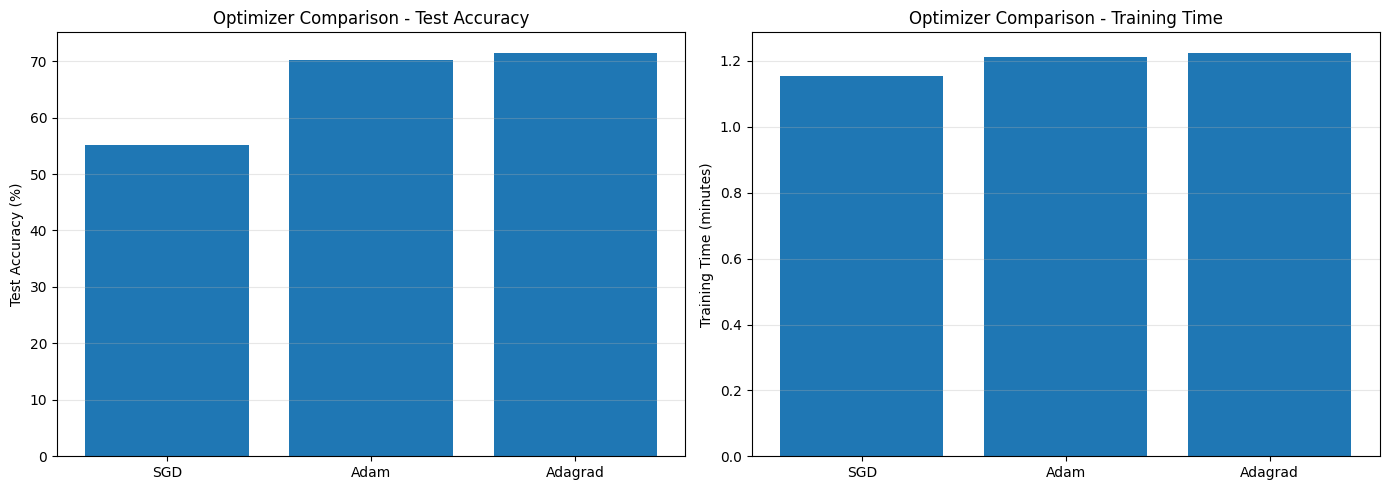

In [35]:
import matplotlib.pyplot as plt

# Plot 1: Optimizer Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

optimizer_data = results_df[results_df['experiment'].str.contains('Task 2|Task 1')]
optimizers = optimizer_data['experiment'].str.extract(r'with (\w+)')[0].values

axes[0].bar(optimizers, optimizer_data['test_acc'])
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Optimizer Comparison - Test Accuracy')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(optimizers, optimizer_data['training_time'])
axes[1].set_ylabel('Training Time (minutes)')
axes[1].set_title('Optimizer Comparison - Training Time')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

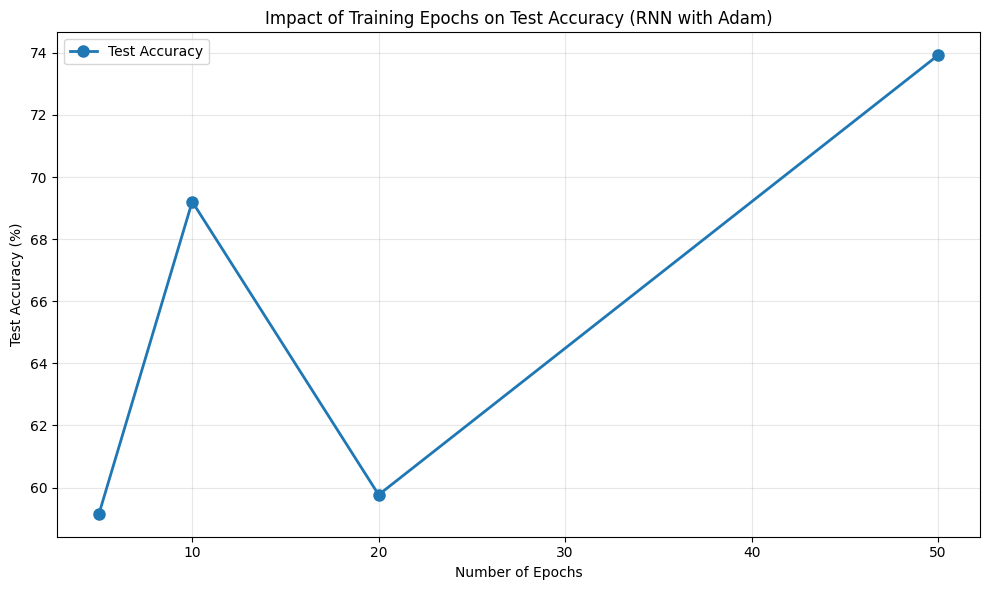

In [36]:
# Plot 2: Epoch Comparison
epoch_data = results_df[results_df['experiment'].str.contains('Task 3')]
epochs = epoch_data['experiment'].str.extract(r'(\d+) epochs')[0].astype(int).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs, epoch_data['test_acc'], 'o-', linewidth=2, markersize=8, label='Test Accuracy')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Impact of Training Epochs on Test Accuracy (RNN with Adam)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('epoch_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

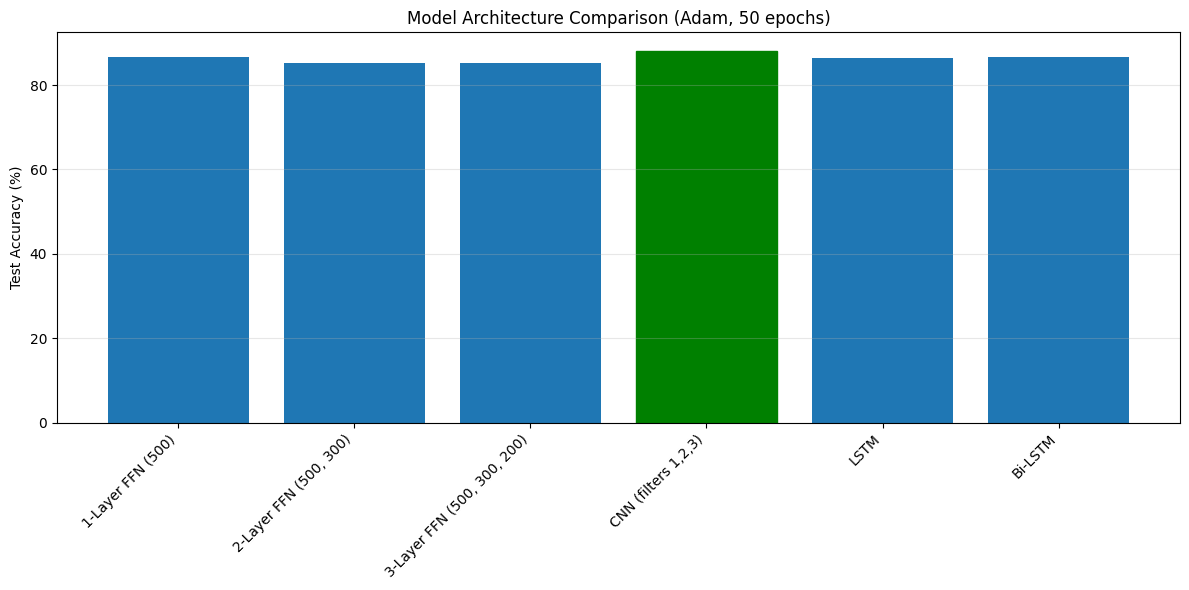

In [37]:
# Plot 3: Model Architecture Comparison
model_data = results_df[results_df['experiment'].str.contains('Task 4')]
model_names = model_data['experiment'].str.replace('Task 4: ', '').values

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(model_names)), model_data['test_acc'])
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Model Architecture Comparison (Adam, 50 epochs)')
ax.grid(axis='y', alpha=0.3)

# Color the best model
best_idx = model_data['test_acc'].idxmax() - model_data.index[0]
bars[best_idx].set_color('green')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings and Analysis

**For your report, consider these analysis points:**

### 1. Optimizer Comparison (Task 2)
- Compare SGD vs Adam vs Adagrad
- Discuss convergence speed and final accuracy
- Explain why Adam typically performs better (adaptive learning rates)

### 2. Effect of Training Epochs (Task 3)
- Show how accuracy improves with more epochs
- Discuss diminishing returns and potential overfitting
- Identify the optimal number of epochs

### 3. Model Architecture Comparison (Task 4)
- Compare simple FFNs vs sequential models (LSTM, Bi-LSTM)
- Discuss why LSTM/Bi-LSTM capture sequential information better
- Analyze the trade-off between model complexity and performance
- Explain CNN's effectiveness in capturing local patterns

### 4. General Observations
- All models use randomly initialized embeddings (not Word2Vec)
- If you had Word2Vec results, you could compare:
  - Pre-trained embeddings capture semantic relationships
  - Random embeddings learn task-specific representations
  - Pre-trained usually gives better performance with less data

### 5. Recommendations
- Best optimizer for this task
- Optimal training duration
- Most effective model architecture

In [38]:
# Find best performing configurations
print("\n" + "="*80)
print("BEST PERFORMING CONFIGURATIONS")
print("="*80)

best_overall = results_df.loc[results_df['test_acc'].idxmax()]
print(f"\nBest Overall Performance:")
print(f"  Experiment: {best_overall['experiment']}")
print(f"  Test Accuracy: {best_overall['test_acc']:.2f}%")
print(f"  Test Loss: {best_overall['test_loss']:.3f}")
print(f"  Training Time: {best_overall['training_time']:.2f} minutes")

# Best by category
print("\nBest by Task:")
for task in ['Task 1', 'Task 2', 'Task 3', 'Task 4']:
    task_data = results_df[results_df['experiment'].str.contains(task)]
    if len(task_data) > 0:
        best = task_data.loc[task_data['test_acc'].idxmax()]
        print(f"\n  {task}: {best['experiment']}")
        print(f"    Test Accuracy: {best['test_acc']:.2f}%")


BEST PERFORMING CONFIGURATIONS

Best Overall Performance:
  Experiment: Task 4: CNN (filters 1,2,3)
  Test Accuracy: 88.10%
  Test Loss: 0.282
  Training Time: 10.36 minutes

Best by Task:

  Task 1: Task 1: RNN with SGD (Baseline)
    Test Accuracy: 55.13%

  Task 2: Task 2: RNN with Adagrad
    Test Accuracy: 71.52%

  Task 3: Task 3: RNN Adam - 50 epochs
    Test Accuracy: 73.92%

  Task 4: Task 4: CNN (filters 1,2,3)
    Test Accuracy: 88.10%


## Report Writing Tips

Use the tables and plots above to create your report. Here's a suggested structure:

### 1. Introduction (0.5 pages)
- Brief overview of sentiment analysis task
- Description of IMDB dataset
- Objectives of the experiments

### 2. Methodology (1 page)
- Data preprocessing
- Model architectures (briefly describe each)
- Training procedure and hyperparameters
- Evaluation metrics

### 3. Results (1.5 pages)
- Present Tables 1, 2, and 3
- Include the comparison plots
- Report best performing configurations

### 4. Analysis and Discussion (1 page)
- **Optimizer comparison**: Why does Adam outperform SGD?
- **Epoch analysis**: Does more training always help?
- **Architecture comparison**: Why do LSTMs work better for sequences?
- **Random vs Pre-trained embeddings**: What would be the expected difference?

### 5. Conclusion (0.5 pages)
- Summary of key findings
- Recommendations for sentiment analysis tasks
- Future work suggestions

**Note**: Keep it concise and focus on insights rather than just reporting numbers!